# Melanoma detection using CNN

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## **Importing all the important libraries**

In [152]:
# TensorFlow and tf.keras for building the CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Image processing libraries
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Sklearn for splitting the data
from sklearn.model_selection import train_test_split
from glob import glob

# Numpy for numerical operations
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt

# OS for file operations
import os
import pandas as pd
import pathlib

from pathlib import Path

In [153]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [154]:
!unzip /content/gdrive/MyDrive/upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration.zip -d /content/gdrive/MyDrive/upgrad/CNN_Assignment

Archive:  /content/gdrive/MyDrive/upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration.zip
   creating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/
   creating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actini

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [155]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [156]:
# image count in train and test folders
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Read Train and Test Images**

Let's load these images off disk using the helpful image_dataset_from_directory utility.


In [157]:
# number of classes
class_names = np.array([item.name for item in data_dir_train.glob('*') if item.name != "LICENSE.txt"])
print(class_names)

['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'seborrheic keratosis'
 'squamous cell carcinoma' 'vascular lesion']


In [158]:
# number of images in each class
for item in class_names:
    print(item + " " + str(len(list(data_dir_train.glob(item + '/*.jpg')))))

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


In [159]:
# define parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [160]:
# Load the images using ImageDataGenerator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [161]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [162]:
# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [163]:
# Print the class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## **Visualize the data**
visualize one instance of all the nine classes present in the dataset

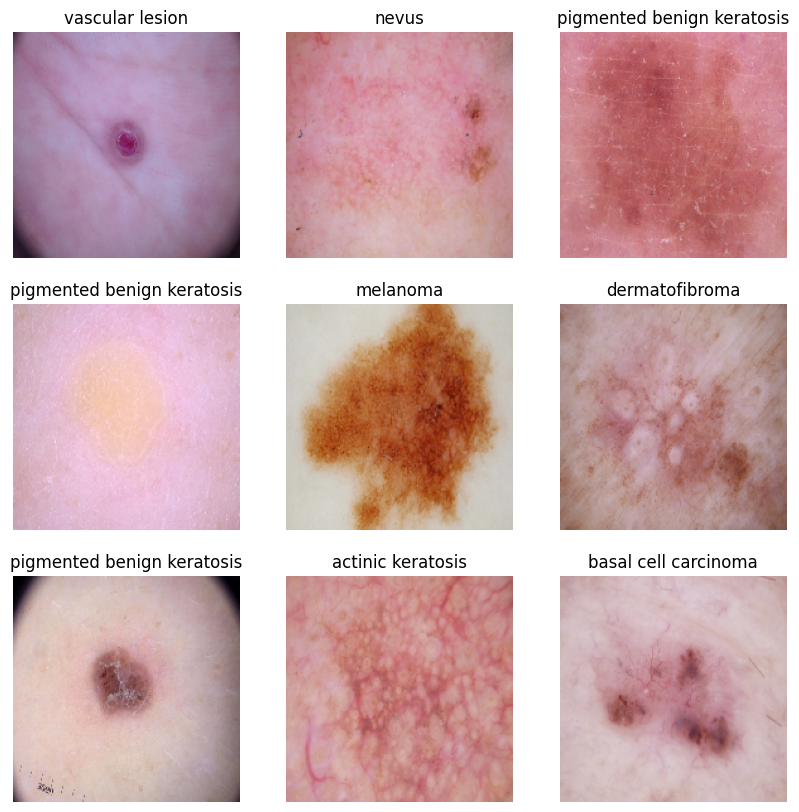

In [164]:
# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [165]:
# Print the shape of the data
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [166]:
# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Create the base model**

#### Create a CNN model, which can accurately detect 9 classes present in the dataset.
*  Normalize pixel values between (0,1)
*  Add Dropout layers

In [167]:
# Normalize the data
from tensorflow.keras import layers
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [168]:
# summarize the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                               

In [169]:
# Compile the model
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [170]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 23s 117ms/step - loss: 2.0668 - accuracy: 0.1892 - val_loss: 2.0447 - val_accuracy: 0.2036 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 2.0147 - accuracy: 0.2227 - val_loss: 1.9737 - val_accuracy: 0.2170 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 1.8972 - accuracy: 0.3002 - val_loss: 1.7945 - val_accuracy: 0.3468 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.7800 - accuracy: 0.3181 - val_loss: 1.6642 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6864 - accuracy: 0.3549 - val_loss: 1.6145 - val_accuracy: 0.4049 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 58ms/step - loss: 1.6294 - accuracy: 0.3873 - val_loss: 1.6090 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1

#### **Visualize Model Results**

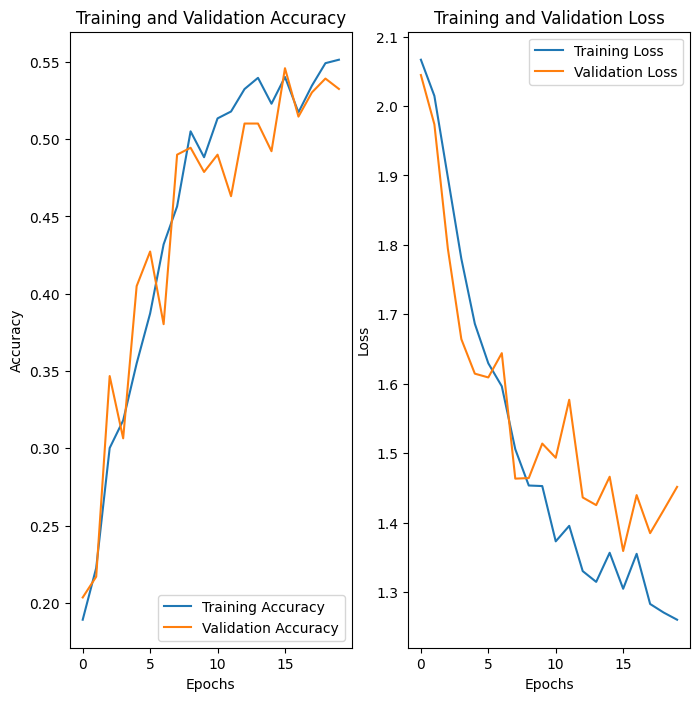

In [171]:
# plot the training and validation accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings**

1. The Traing accuracy and validation accuracy are almost same, but very low which indicates that the model is underfitting
2. Training loss is very low, but validation loss is fluctuating.

    Thus we can infer that the model is not good.


## **Create the model with Data Augmentation**
 Create a CNN model again which can accurately detect 9 classes present in the dataset with the following added -
*   Data Augmentation
*   Normalize pixel values between (0,1)
*   Add Dropout layers



In [172]:
# Drop in accuracy, add data augmentation to increase the accuracy
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

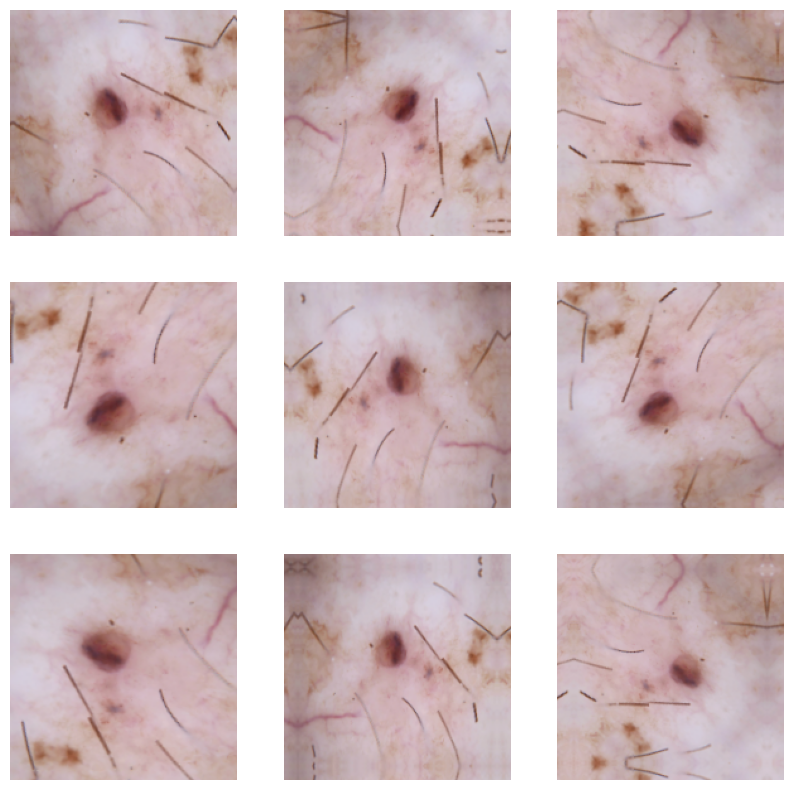

In [173]:
# Visualize the augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [174]:
# Create the model
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [175]:
# summarize the model
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 64)        18496     
                                                     

In [176]:
# Compile the model
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [177]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 7s 64ms/step - loss: 2.0803 - accuracy: 0.1674 - val_loss: 2.1019 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 2.0370 - accuracy: 0.2009 - val_loss: 2.0264 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 2.0195 - accuracy: 0.2132 - val_loss: 2.0234 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 59ms/step - loss: 2.0214 - accuracy: 0.2009 - val_loss: 2.0243 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0185 - accuracy: 0.1992 - val_loss: 2.0248 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - ETA: 0s - loss: 2.0193 - accuracy: 0.1858
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 [==============================] - 3s 59ms/step - los

#### **Visualize Model Results**

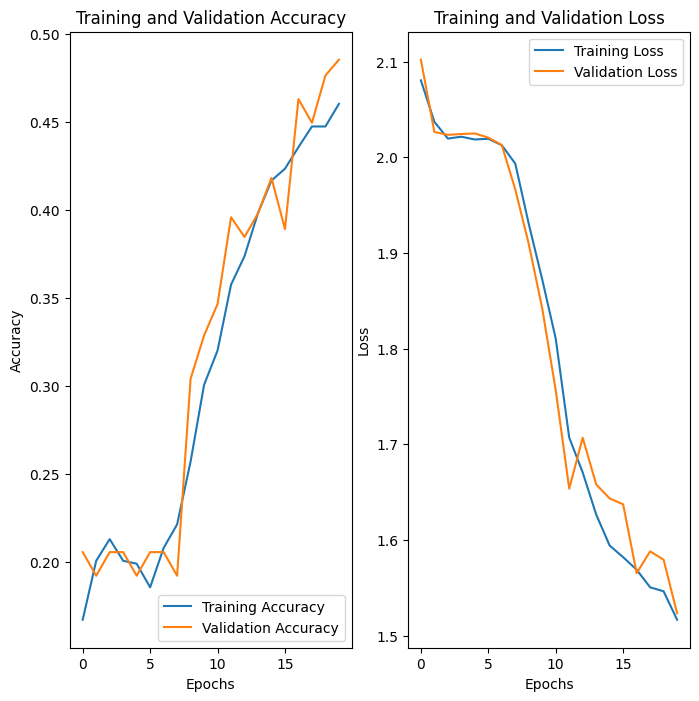

In [178]:
# plot the training and validation accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

**Findings**

* The Training accuracy and validation accuracy are almost same.
* This is a sign of good fit but the accuracy is still very low.
* The model requires more epochs to train with class imbalance handled.

### **Class Imbalance in the Training dataset**

In [179]:
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

<ipython-input-179-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-179-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-179-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-179-d5ac25318fed>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)


,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

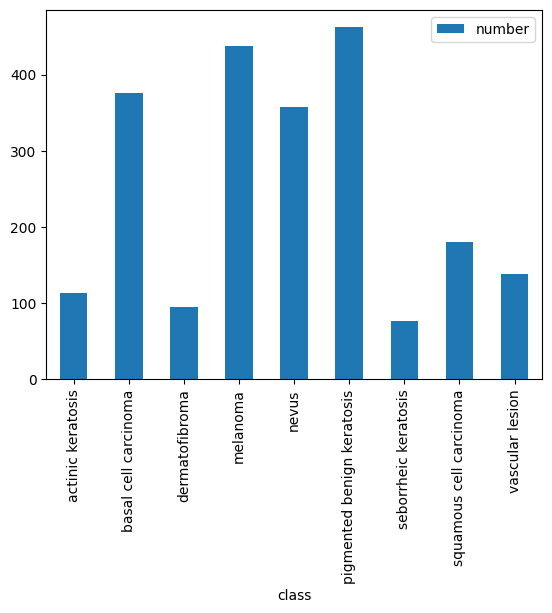

In [180]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

In [181]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

## **Create a model with Class rebalance**
Create a CNN model again which can accurately detect 9 classes present in the dataset with the following added -
*   Fix class imbalance using Augmentor library
*   Normalize pixel values between (0,1)
*   Add Dropout layers

In [182]:
# use augmentor to increase the accuracy
!pip install Augmentor

In [183]:
# import the libraries
import Augmentor

In [184]:
# define the path
path_to_training_dataset="/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D2E973A2470>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D2E9704EBC0>: 100%|██████████| 500/500 [00:24<00:00, 20.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D2E96D38160>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7D2E9704EBC0>: 100%|██████████| 500/500 [01:39<00:00,  5.02 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7D2E9A1DBBB0>: 100%|██████████| 500/500 [01:18<00:00,  6.35 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D2E971DAD10>: 100%|██████████| 500/500 [00:18<00:00, 27.41 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D2E96B41DB0>: 100%|██████████| 500/500 [00:38<00:00, 12.86 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D2E9721C490>: 100%|██████████| 500/500 [00:17<00:00, 28.52 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D2E99CF6AA0>: 100%|██████████| 500/500 [00:17<00:00, 27.92 Samples/s]


In [185]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [186]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_6cc76c55-ce25-4e46-bfda-e2ad0bcbaa6d.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_b062b16b-c600-4e61-bdd7-fc1b1587ea64.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_dfa317f8-eed4-43e2-8f6a-0b212d55cfa1.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_df589d57-892b-429f-8217-6976bf734b6e.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin 

In [187]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [188]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [189]:
for i in class_names:
    directory ='/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
    directory_out ='/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


In [190]:
batch_size = 32
img_height = 180
img_width = 180

In [191]:
# read the images
data_dir_train="/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [192]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [193]:
# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [194]:
# Create the model
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

In [195]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [196]:
# Train the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/30
169/169 [==============================] - 63s 110ms/step - loss: 2.1282 - accuracy: 0.1649 - val_loss: 1.9101 - val_accuracy: 0.2628 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 10s 61ms/step - loss: 1.9092 - accuracy: 0.2452 - val_loss: 1.8167 - val_accuracy: 0.3044 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 10s 62ms/step - loss: 1.6958 - accuracy: 0.3581 - val_loss: 1.7817 - val_accuracy: 0.3630 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 10s 61ms/step - loss: 1.6378 - accuracy: 0.3704 - val_loss: 1.4464 - val_accuracy: 0.4365 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 10s 60ms/step - loss: 1.4957 - accuracy: 0.4212 - val_loss: 1.3544 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 11s 62ms/step - loss: 1.4631 - accuracy: 0.4305 - val_loss: 1.3684 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 7/30
169/169 [==============================] - 10s

#### **Visualize Model Results**

Text(0.5, 1.0, 'Training and Validation Loss')

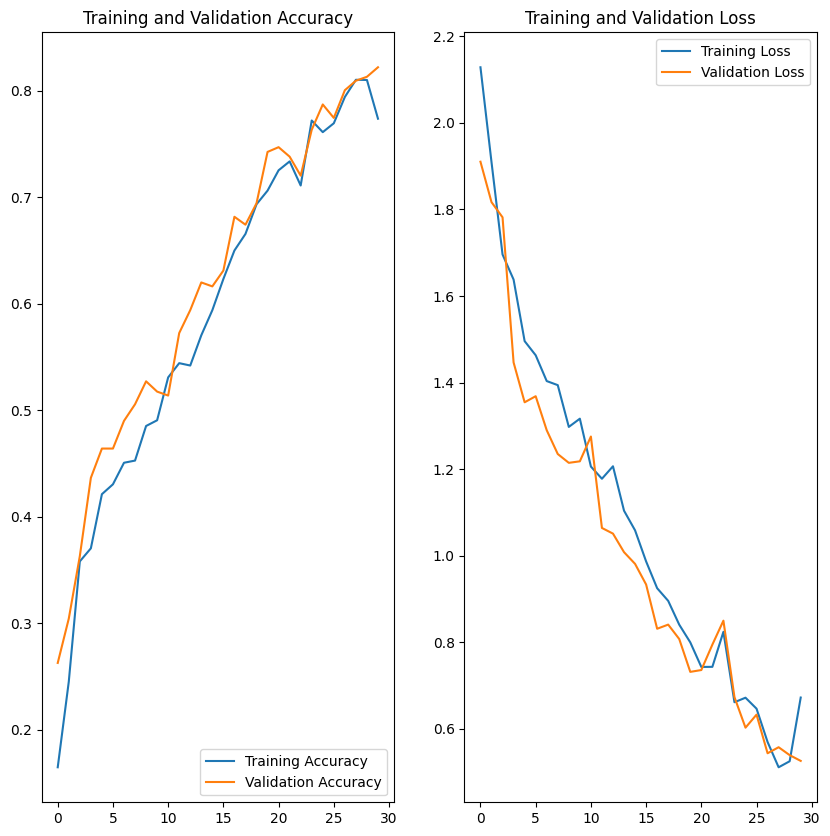

In [197]:
# plot the training and validation accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(epochs)

# plot the training and validation accuracy and loss at each epoch
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


**Findings**

* The training accuracy and validation accuracy are almost same. This is a sign of good fit.
* The training loss and validation loss are almost same. This is a sign of good fit.
* The Validation accuracy is 0.82 which is good. The model is able to classify the images with 82% accuracy
* Class rebalance helped to improve the validation accuracy

1/1 [==============================] - 0s 195ms/step
Actual Class: vascular lesion
Predictive Class: vascular lesion


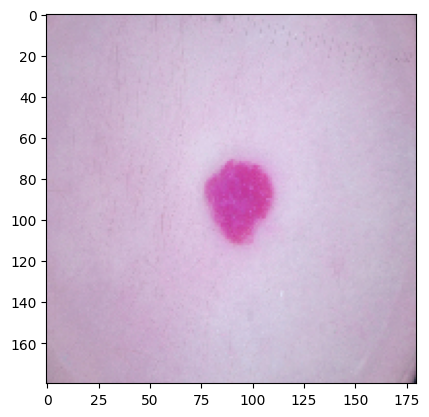

In [198]:
Test_image_path = os.path.join(data_dir_test, class_names[8], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[8]}" + '\n' + "Predictive Class: " + pred_class)